# Bulk functional analysis

Bulk RNA-seq yields many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by inferring pathway and transcription factor activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for transcription factor (TF) and pathway activity inference from a human data-set. The data consists of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming growth factor (TGF-β), it is available at GEO [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151251).

バルクRNA-seqからは、それだけでは解釈が難しい多くの分子情報が得られる。このような情報を要約する一つの方法は、事前の知識からパスウェイや転写因子の活性を推測することです。

このノートブックでは、ヒトのデータセットから転写因子（TF）とパスウェイの活性推論にdecouplerを使用する方法を紹介します。データは6サンプルの肝星細胞（HSC）からなり、そのうち3サンプルはサイトカインTGF-βによって活性化されている。

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle RNA-seq data
and `decoupler` to use statistical methods.

まず、関連するパッケージ、RNA-seqデータを扱うscanpyと統計的手法を使うdecouplerをロードする必要がある。

In [1]:
# Only needed for processing
import numpy as np

In [2]:
import pandas as pd

In [3]:
from anndata import AnnData

In [4]:
import scanpy as sc

In [5]:
import decoupler as dc

In [13]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

## Loading the data

We can download the data easily from GEO:

データはGEOから簡単にダウンロードできる：

In [6]:
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz

--2024-08-08 22:35:49--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov) をDNSに問いあわせています... 130.14.29.110
www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 1578642 (1.5M) [application/octet-stream]
`counts.txt.gz' に保存中

counts.txt.gz       100%[===================>]   1.50M  1.31MB/s 時間 1.2s       

2024-08-08 22:35:51 (1.31 MB/s) - `counts.txt.gz' へ保存完了 [1578642/1578642]



In [7]:
!gzip -d -f counts.txt.gz

We can then read it using `pandas`:

そしてpandasを使ってそれを読むことができる：

In [14]:
# Read raw data and process it
adata = pd.read_csv('counts.txt', index_col=2, sep='\t').iloc[:, 5:].T

In [15]:
adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In case your data does not contain gene symbols but rather gene ids like ENSMBL, you can use the function `sc.queries.biomart_annotations` to retrieve them.
In this other [vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html), ENSMBL ids are transformed into gene symbols.

In case your data is not from human but rather a model organism, you can find their human orthologs using `pypath`.
Check this GitHub [issue](https://github.com/saezlab/decoupler-py/issues/5#issuecomment-1137099265) where mouse genes are transformed into human.

The obtained data consist of raw read counts for six different samples (three controls, three treatments) for ~60k genes.
Before continuing, we will transform our expression data into an `AnnData` object. It handles annotated data matrices
efficiently in memory and on disk and is used in the scverse framework. You can read more about it 
[here](https://scverse.org/) and [here](https://anndata.readthedocs.io/en/latest/).

データ中に遺伝子シンボルが含まれておらず、ENSMBLのような遺伝子idが含まれている場合は、sc.queries.biomart_annotations関数を用いて遺伝子シンボルを取得することができる。この他のビネットでは、ENSMBLのidを遺伝子シンボルに変換している。

データがヒトではなくモデル生物のものである場合、pypathを使ってヒトのオルソログを検索することができます。マウス遺伝子をヒト遺伝子に変換したGitHub issueを参照してください。

得られたデータは、6つの異なるサンプル（3つのコントロール、3つのトリートメント）の~60k遺伝子の生のリードカウントからなる。続行する前に、発現データをAnnDataオブジェクトに変換する。AnnDataオブジェクトはアノテーションされたデータ行列をメモリ上とディスク上で効率的に処理するもので、scverseフレームワークで使用されている。詳しくはこちらとこちらをご覧ください。

In [16]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)

In [17]:
adata.var_names_make_unique()

In [18]:
adata

AnnData object with n_obs × n_vars = 6 × 64253

Inside an `AnnData` object, there is the `.obs` attribute where we can store the metadata of our samples.
Here we will infer the metadata by processing the sample ids, but this could also be added from a separate dataframe:

AnnData オブジェクトの内部には、.obs 属性があり、ここにサンプルのメタデータを格納することができる。ここでは、サンプルIDを処理することでメタデータを推測しますが、別のデータフレームから追加することもできます：

In [19]:
# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

In [20]:
# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

In [21]:
# Visualize metadata
adata.obs.head()

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32


## Quality control

Before doing anything we need to ensure that our data passes some quality control thresholds. In transcriptomics it can happen
that some genes were not properly profiled and thus need to be removed.

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

何かをする前に、データが品質管理のしきい値に合格していることを確認する必要がある。トランスクリプトミクスでは、いくつかの遺伝子が適切にプロファイリングされていないことが起こり得るので、除去する必要がある。

遺伝子をフィルターするために、edgeRのfilterByExpr関数に実装されている戦略に従う。これは、サンプル全体のリード総数が最小（min_total_count）で、サンプル数のカウント数が最小（min_count）の遺伝子を保持する。

min_countとmin_total_countを弄ることで、いくつの遺伝子を残すかをプロットできる：

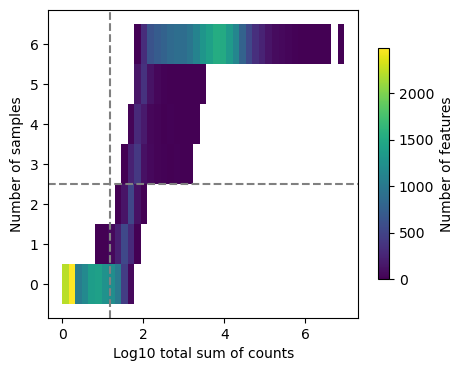

In [22]:
dc.plot_filter_by_expr(
    adata, group='condition',
    min_count=10, min_total_count=15,
    large_n=1, min_prop=1
)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters. 

This thresholds can vary a lot between datasets, manual assessment of them needs to be considered. For example, it might be
the case that many genes are not expressed in just one sample which they would get removed by the current setting. For this
specific dataset it is fine.

Once we are content with the threshold parameters, we can perform the actual filtering:

ここでは、総カウント数とサンプル数が異なる遺伝子の頻度を観察できる。破線は現在の閾値を示し、右上隅の遺伝子だけが保持されることを意味する。パラメーターのフィルタリングは完全に任意であるが、経験則としては、二峰性の分布を識別し、利用可能な閾値を変更してそれらを分割することである。この例では、デフォルト値で、潜在的にノイズの多い遺伝子をフィルタリングしながら、十分な量の遺伝子を残すことになる。

min_countの値を変更すると、"Number of samples "の分布が大きく変わるが、閾値は変わらない。閾値を下げたり上げたりしたい場合は、group、large_n、min_propパラメータを調整する必要がある。

このしきい値は、データセットによって大きく異なる可能性があり、手動での評価を考慮する必要がある。例えば、多くの遺伝子がたった1つのサンプルで発現しておらず、現在の設定では除去されてしまうような場合があるかもしれない。このデータセットでは問題ない。

閾値パラメータに満足したら、実際のフィルタリングを行うことができる：

In [23]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(
    adata, group='condition',
    min_count=10, min_total_count=15,
    large_n=1, min_prop=1
)

In [24]:
# Filter by these genes
adata = adata[:, genes].copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 6 × 19713
    obs: 'condition', 'sample_id'

## Differential expression analysis

In order to identify which are the genes that are changing the most between treatment and control we can perform differential
expression analysis (DEA). For this example, we will perform a simple experimental design where we compare the gene expression
of treated cells against controls. We will use the python implementation of the framework DESeq2, but we could have used any
other one (`limma` or `edgeR` for example). For a better understanding how it works, check
[DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that more complex experimental designs can be used
by adding more factors to the `design_factors` argument.

処理とコントロールの間で最も変化している遺伝子を特定するために、差次 発現解析（DEA）を行うことができる。この例では、処理した細胞の遺伝子発現をコントロールと比較する単純な実験計画を行う。DESeq2フレームワークのpython実装を使用しますが、他のもの（例えばlimmaやedgeR）を使用することもできます。DESeq2がどのように機能するかについては、DESeq2のドキュメントを参照されたい。design_factors引数に因子を追加することで、より複雑な実験計画を使用できることに注意してください。

In [26]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [27]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)

In [28]:
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    inference=inference,
)

In [29]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 6.22 seconds.

Fitting dispersion trend curve...
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 7.64 seconds.

Fitting LFCs...
... done in 3.13 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [30]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'treatment', 'control'],
    inference=inference
)

In [31]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
WASH7P           10.349784       -0.011131  0.651869 -0.017076  0.986376   
MIR6859-1        10.114621        0.000629  0.657529  0.000956  0.999237   
RP11-34P13.7     45.731312        0.078209  0.324481  0.241027  0.809534   
RP11-34P13.8     29.498379       -0.065180  0.393676 -0.165567  0.868498   
CICP27          106.032659        0.150597  0.222996  0.675332  0.499465   
...                    ...             ...       ...       ...       ...   
MT-ND6        17914.984474       -0.435304  0.278796 -1.561372  0.118436   
MT-TE          1281.293477       -0.332495  0.288073 -1.154204  0.248416   
MT-CYB        54955.449372       -0.313285  0.286900 -1.091966  0.274848   
MT-TT           204.692221       -0.485883  0.220577 -2.202783  0.027610   
MT-TP           345

... done in 1.29 seconds.



In [32]:
# Extract results
results_df = stat_res.results_df

In [33]:
results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
WASH7P,10.349784,-0.011131,0.651869,-0.017076,0.986376,0.991406
MIR6859-1,10.114621,0.000629,0.657529,0.000956,0.999237,0.999517
RP11-34P13.7,45.731312,0.078209,0.324481,0.241027,0.809534,0.877406
RP11-34P13.8,29.498379,-0.065180,0.393676,-0.165567,0.868498,0.917099
CICP27,106.032659,0.150597,0.222996,0.675332,0.499465,0.637279


We can plot the obtained results in a volcano plot:

得られた結果をボルケーノプロットにプロットすることができる：

/Users/tomoya/mambaforge/envs/py_scvi/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


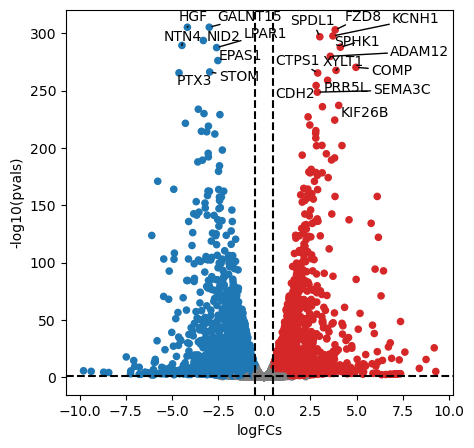

In [34]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(5, 5)
)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

DEAを行った後、得られた遺伝子レベルの統計量を用いて濃縮解析を行うことができる。どのような統計量でも使用できるが、logFCの代わりにt値を使用することを推奨する。t値はその値に変化の有意性が含まれているからである。statsに格納されたt値をワイド行列に変換し、decouplerで利用できるようにする：

In [35]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})

In [36]:
mat

GeneName,WASH7P,MIR6859-1,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,-0.017076,0.000956,0.241027,-0.165567,0.675332,-1.645555,2.041528,-0.376872,-1.994784,-0.498507,...,-1.435973,0.755042,1.139185,1.167225,-1.242576,-1.561372,-1.154204,-1.091966,-2.202783,-2.849413


## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

最初に行う機能解析は、トランスクリプトミクスデータから転写因子（TF）活性を推測することである。遺伝子制御ネットワーク（GRN）と統計的手法が必要です。

CollecTRIは、12の異なるリソースからコンパイルされたTFとその転写ターゲットのキュレーションコレクションを含む包括的なリソースです。このコレクションは、以前のDoRothEAネットワークや他の文献ベースのGRNと比較して、転写因子のカバレッジを高め、摂動TFの同定において優れたパフォーマンスを提供します。DoRothEAと同様に、相互作用はその調節様式（活性化または阻害）によって重み付けされる。

この例ではヒトのバージョンを使用する（マウスとラットも利用可能）。decouplerを使ってomnipathから取り出すことができる。引数split_complexesは複合体を保持するか、サブユニットに分割するかを指定する。デフォルトでは複合体を保持することを推奨する。

このチュートリアルでは、CollecTRI ネットワークを使用しますが、CellOracle、pySCENIC、SCENIC+ などの推論メソッドから得られる他のGRNを使用することもできます。

In [37]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [38]:
collectri.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

We can run `ulm` with a one-liner:

TF濃縮スコアを推測するために、一変量線形モデル（ulm）法を実行する。データセットの各サンプル（mat）とネットワークの各TF（net）について、TFのTF-遺伝子相互作用の重みのみに基づいて、観測された遺伝子発現を予測する線形モデルを当てはめる。フィッティング後、得られた傾きのt値がスコアとなる。これが正であればTFは活性であると解釈し、負であれば不活性であると解釈する。

ulmはワンライナーで実行できる：

In [39]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)

Running ulm on mat with 1 samples and 19713 targets for 655 sources.


In [40]:
tf_acts

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
treatment.vs.control,-2.181049,-1.569994,-1.823752,-1.984969,-2.67189,0.216338,-3.935449,0.871064,1.65003,-0.612386,...,-0.062561,2.122393,1.888035,-1.140309,-1.570972,-1.276408,-0.116691,3.374288,0.919301,-2.743996


Let us plot the obtained scores for the top active/inactive transcription factors:

上位の活性／不活性転写因子について、得られたスコアをプロットしてみよう：

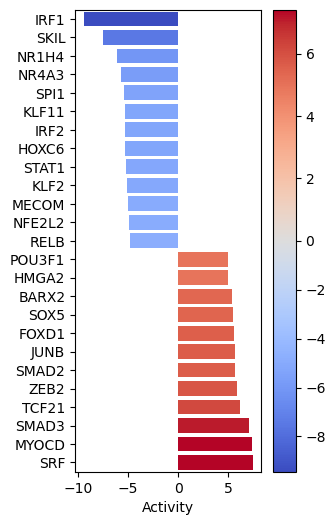

In [41]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

MYOCD SRF and JUNB seem to be the most activated in this treatment while IRF1, KLF11 AND ARID1A seem to be inactivated.

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

IRF1、KLF11、ARID1Aは不活性化されているようだが、MYOCD SRFとJUNBはこの処理で最も活性化されているようだ。

興味深いTFのネットワークをプロットし（活性別に上下に）、活性と標的遺伝子の発現によってノードを色分けすることもできる：

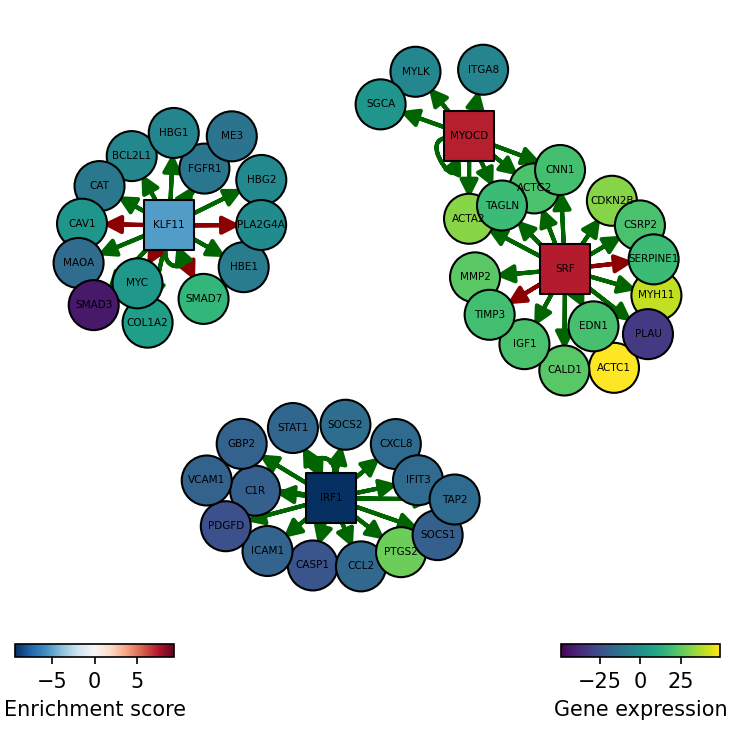

In [42]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYOCD', 'SRF', 'IRF1', 'KLF11'],
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

SRF seems to be active in treated cells since their positive targets are up-regulated.

If needed, we can also look at a volcano plot of the target genes:

SRFのポジティブターゲットがアップレギュレートされているので、SRFは処理された細胞で活性化しているようだ。

必要であれば、標的遺伝子のボルケーノプロットを見ることもできる：

In [43]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

/Users/tomoya/mambaforge/envs/py_scvi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


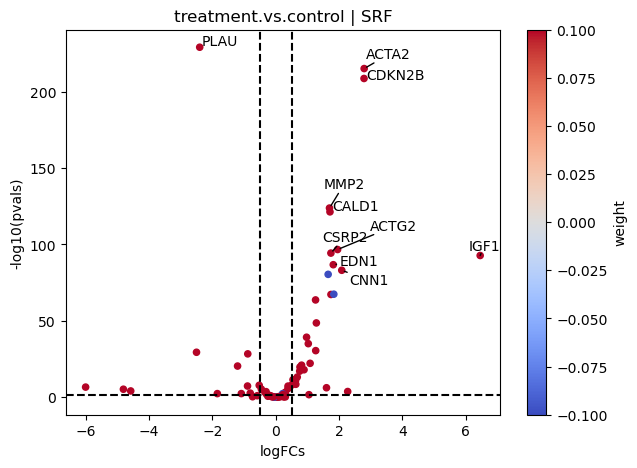

In [44]:
# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'treatment.vs.control',
    name='SRF',
    net=collectri,
    top=10,
    sign_thr=0.05,
    lFCs_thr=0.5
)

## Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

トランスクリプトミクスのデータからパスウェイの活性を推測することもできる。

PROGENyは、パスウェイとその標的遺伝子のキュレーションコレクションを含む包括的なリソースであり、各相互作用の重み付けがなされている。この例ではヒトの重みを使用し（他の生物も利用可能）、p値でランク付けされた上位500の応答遺伝子を使用する。以下に各経路の簡単な説明をする：

- アンドロゲン：男性生殖器の成長と発達に関与する。
- EGFR：哺乳類細胞の成長、生存、遊走、アポトーシス、増殖、分化を制御する。
- エストロゲン：女性の生殖器の成長と発達を促進する。
- 低酸素：酸素濃度が低い場合、血管新生と代謝の再プログラミングを促進する。
- JAK-STAT：免疫、細胞分裂、細胞死、腫瘍形成に関与する。
- MAPK：外部シグナルを統合し、細胞の成長と増殖を促進する。
- NFkB：免疫応答、サイトカイン産生、細胞生存を制御する。
- p53：細胞周期、アポトーシス、DNA修復、腫瘍抑制を制御する。
- PI3K：成長と増殖を促進する。
- TGFb：ほとんどの組織の発生、恒常性維持、修復に関与する。
- TNFa：造血、免疫監視、腫瘍退縮、感染防御を媒介する。
- トレイル：アポトーシスを誘導する。
- VEGF：血管新生、血管透過性、細胞移動を媒介する。
- WNT：発生と組織修復における器官の形態形成を制御する。

これにアクセスするには、デカップラーを使用することができる。

In [45]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)

In [46]:
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
     
We can run `mlm` with a one-liner:

パスウェイ濃縮スコアを推論するために、多変量線形モデル（mlm）法を実行する。データセット(adata)の各サンプルについて、すべてのパスウェイのPathway-Gene相互作用の重みに基づいて、観測された遺伝子発現を予測する線形モデルをフィットする。フィッティング後、得られた傾きのt値がスコアとなる。これが正であればパスウェイは活性であり、負であれば不活性であると解釈する。

mlmはワンライナーで実行できる：

In [47]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)

Running mlm on mat with 1 samples and 19713 targets for 14 sources.


In [48]:
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
treatment.vs.control,1.441108,-1.320373,1.547335,8.076818,-12.994632,8.003248,1.431378,7.49256,45.605988,-6.973096,-1.449625,3.469314,-0.449229,-5.729536


Let us plot the obtained scores:

得られたスコアをプロットしてみよう：

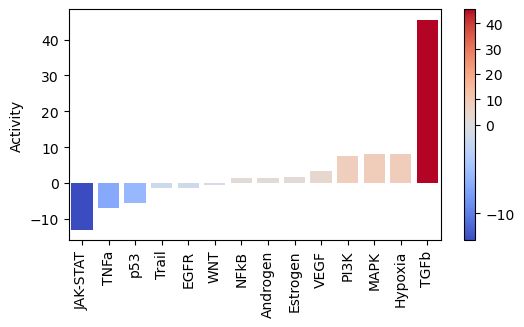

In [49]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

As expected, after treating cells with the cytokine TGFb we see an increase of activity for this pathway.

On the other hand, it seems that this treatment has decreased the activity of other pathways like JAK-STAT or TNFa.

We can visualize the targets of TFGb in a scatter plot:

予想通り、サイトカインTGFbで細胞を処理すると、この経路の活性が上昇した。

一方、この処理によってJAK-STATやTNFaのような他の経路の活性は低下したようである。

TFGbの標的を散布図で可視化することができる：

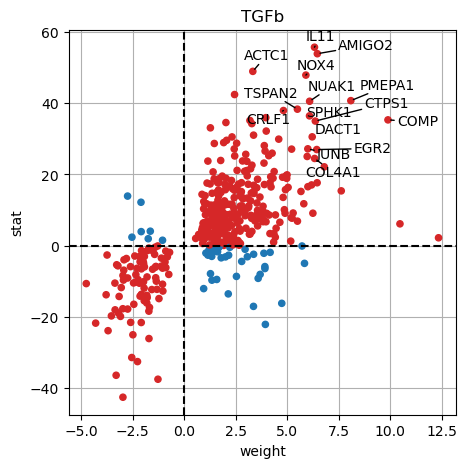

In [50]:
dc.plot_targets(
    results_df, stat='stat',
    source_name='TGFb', net=progeny, top=15
)

The observed activation of TGFb is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

TGFbの活性化が観察されるのは、正の重みを持つ標的遺伝子の大半が正のt値を持ち（第1象限）、負の重みを持つ標的遺伝子の大半が負のt値を持つ（第3象限）からである。

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

最後に、一般的な生物学的用語やプロセスの活性を推測することもできる。

Molecular Signatures Database (MSigDB)は、様々な生物学的プロセスにアノテーションされた遺伝子セットのコレクションを含むリソース。

In [51]:
msigdb = dc.get_resource('MSigDB')

In [52]:
msigdb.head()

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP


As an example, we will use the hallmark gene sets, but we could have used any other. 
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`. 

We can filter by for `hallmark`:

例として、hallmark 遺伝子セットを使用するが、他のものでもよい。

MSigDBで利用可能な他のコレクションを見るには、次のように入力します： msigdb['collection'].unique().

hallmarkでフィルターできる：

In [53]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection'] == 'hallmark']

In [54]:
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

In [55]:
# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

In [56]:
msigdb.head()

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT


### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
     
We can run `ora` with a simple one-liner:

機能的濃縮スコアを推測するために、Over Representation Analysis (ora)メソッドを実行する。入力データとして、発現行列(decoupler.run_ora)または差分発現解析結果(decoupler.run_ora_df)を受け取る。前者では、デフォルトでサンプルごとの発現遺伝子の上位5％が注目セット（S*）として選択され、後者ではユーザー定義の有意性フィルタリングを使用できる。S*が得られたら、使用する遺伝子セットリソース（net）に格納されている各セットについて、セット操作を使用して分割表を作成する。分割表を用いて、oraはセット間の重複の有意性を検定するために片側フィッシャー正確検定を実行する。最終的なスコアは得られたp値を対数変換することで得られ、値が大きいほど有意であることを意味する。

oraは簡単なワンライナーで実行できる：

In [57]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

In [58]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

In [59]:
enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.540000,0.000815,0.002146,1.270075,9.032492,ABCA1;ACADM;ACADS;ACLY;ACOX1;ADCY6;ADIPOR2;AGP...
1,ALLOGRAFT_REJECTION,200,0.350000,0.989530,0.999999,0.821555,0.008647,ABCE1;ABI1;APBB1;B2M;BCAT1;BCL3;C2;CCL2;CCND3;...
2,ANDROGEN_RESPONSE,100,0.570000,0.002756,0.006562,1.341486,7.906716,ABCC4;ACTN1;ADAMTS1;ALDH1A3;ANKH;ARID5B;B2M;B4...
3,ANGIOGENESIS,36,0.555556,0.083007,0.119856,1.315378,3.273752,COL3A1;CXCL6;FGFR1;FSTL1;ITGAV;JAG1;LRPAP1;LUM...
4,APICAL_JUNCTION,200,0.525000,0.003229,0.007020,1.234518,7.080522,ACTA1;ACTB;ACTC1;ACTG1;ACTG2;ACTN1;ACTN4;ADAM1...


Then we can visualize the most enriched terms:

そして、最もエンリッチされた用語を視覚化することができる：

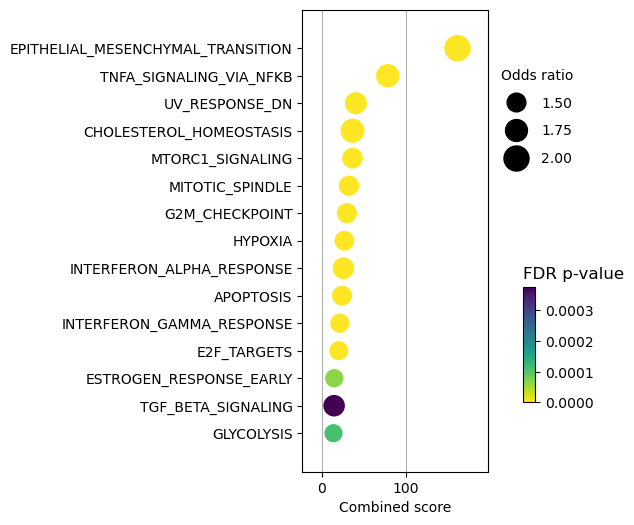

In [60]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=1.5,
    figsize=(3, 6)
)

TNFa and interferons response (JAK-STAT) processes seem to be enriched. We previously observed a similar result with the PROGENy pathways, were they were significantly downregulated. Therefore, one of the limitations of using a prior knowledge resource without weights is that it doesn't provide direction.

We can also plot the running score for a given gene set:

TNFaとインターフェロン応答（JAK-STAT）過程が濃縮されているようである。我々は以前、PROGENy経路で同様の結果を観察し、それらは有意にダウンレギュレートされていた。従って、重みなしの事前知識リソースを使うことの限界の一つは、方向性を示さないことである。

与えられた遺伝子セットのランニングスコアをプロットすることもできる：

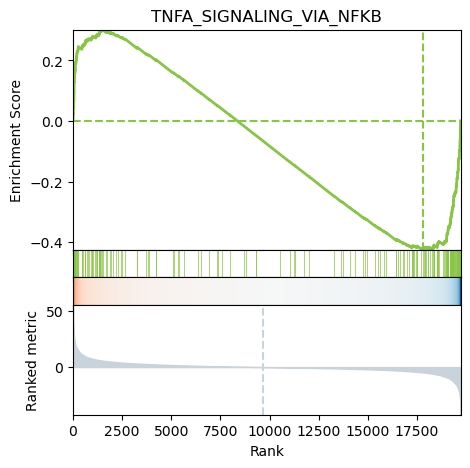

In [61]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='TNFA_SIGNALING_VIA_NFKB'
)

## Enrichment of ligand-receptor interactions

Recently, study of interactions between ligands and receptors have gained significant traction, notably pushed by the democratization of single cell sequencing technologies. While most methods (such as the one described in LIANA) are developed for single cell datasets, they rely on a relatively simple assumption of co-expression or co-regulation of two (or more in the context of complexes) genes acting as ligand and receptors to propose hypothetical ligand-receptor interaction events. This concept can seamlessly be applied to a bulk RNA dataset, where the assumption is that sender and receiver cells are convoluted in a single dataset, but the observation of significant co-regulation of ligand and receptors should still correspond to hypothetical ligand-receptor interaction events.

At the core, most current ligand-receptor interaction methods rely on averaging the measurements obtained for ligand and receptor and standardizing them against a background distribution.  Thus, an enrichment method based on a weighted mean can emulate this, where the sets are simply the members of a ligand receptor pair (or more in the context of complexes).

Thus, we can extract ligand-receptor interaction ressources from the LIANA package (available both in [R](https://saezlab.github.io/liana/) and [python](https://liana-py.readthedocs.io/en/latest/)), and use it as a prior knowledge network with decoupler to find the most significant pairs of ligand-receptors in a given bulk dataset.

While more work is required to fully understand the functional relevance of the highlighted ligand-receptor interactions with such an approach, this represents a very straightforward and intuitive approach to embed a bulk RNA dataset with ligand-receptor interaction prior knowledge.


First, we extract ligand-receptor interactions from liana, and decomplexify them to format them into an appropriate decoupleR input.

近年、リガンドとレセプター間の相互作用の研究は、特にシングルセルシーケンス技術の民主化に後押しされ、大きな盛り上がりを見せている。LIANAに記載されているような）ほとんどの方法はシングルセルデータセット用に開発されたものであるが、リガンドとレセプターとして働く2つ（複合体の場合はそれ以上）の遺伝子の共発現あるいは共制御という比較的単純な仮定に依存して、仮説的なリガンドとレセプターの相互作用事象を提唱している。このコンセプトはバルクRNAデータセットにシームレスに適用することができ、そこでは送り手と受け手の細胞は単一のデータセットの中で錯綜しているという仮定が成り立つが、リガンドとレセプターの有意な共制御の観察は、やはり仮説的なリガンド-レセプター相互作用イベントに対応するはずである。

現在のリガンド-レセプター相互作用法のほとんどは、リガンドとレセプターについて得られた測定値を平均化し、バックグラウンド分布に対して標準化することに依存している。従って、加重平均に基づく濃縮法はこれをエミュレートすることができ、そこではセットは単にリガンド・レセプター対のメンバー（複合体の文脈ではそれ以上）である。

このように、我々はLIANAパッケージ（Rとpythonの両方で利用可能）からリガンド-受容体相互作用リソースを抽出し、与えられたバルクデータセットから最も重要なリガンド-受容体のペアを見つけるために、デカップラーを用いた事前知識ネットワークとして使用することができる。

このようなアプローチでハイライトされたリガンド-レセプター相互作用の機能的関連性を完全に理解するためにはさらなる研究が必要であるが、これはバルクRNAデータセットにリガンド-レセプター相互作用の事前知識を埋め込むための非常に簡単で直感的なアプローチである。

まず、リガンドとレセプターの相互作用をlianaから抽出し、適切なdecoupleR入力にフォーマットするために、それらを脱複雑化する。

In [62]:
import liana as ln

In [63]:
liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

In [64]:
# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

In [65]:
# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

In [66]:
# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

In [67]:
# Find duplicated rows
duplicates = liana_lr.duplicated()

In [68]:
# Remove duplicated rows
liana_lr = liana_lr[~duplicates]

In [69]:
liana_lr.head()

,interaction,genes,weight
0,LGALS9&PTPRC,LGALS9,1
1,LGALS9&MET,LGALS9,1
2,LGALS9&CD44,LGALS9,1
3,LGALS9&LRP1,LGALS9,1
4,LGALS9&CD47,LGALS9,1


Then we can use `ulm` to find the significant co-regulated pairs of ligand and receptors.

そしてulmを使って、リガンドとレセプターの重要な共制御ペアを見つけることができる。

In [70]:
# Infer lr activities with ulm
lr_score, lr_pvalue = dc.run_ulm(
    mat=mat,
    net=liana_lr,
    source='interaction',
    target='genes',
    min_n=2,
    verbose=True
)

Running ulm on mat with 1 samples and 19713 targets for 2112 sources.


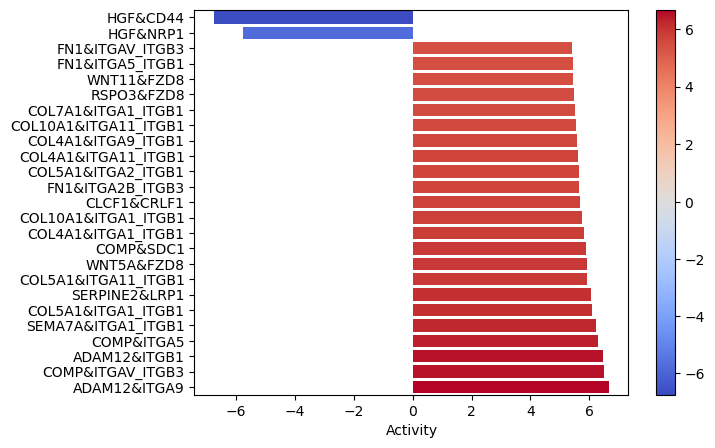

In [71]:
dc.plot_barplot(lr_score, 'treatment.vs.control', top=25, vertical=True)

Interactions between colagens and the ITG_ITG complexes seems to be quite enrichned. That is especially relevant since the EMT pathway was significantly enriched in the functional pathway analysis.

コラーゲンとITG_ITG複合体との相互作用はかなり濃縮されているようだ。機能パスウェイ解析でEMT経路が有意に濃縮されたので、これは特に関連性が高い。